### loading packages

In [1]:
import os
import glob
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# webscraping Q data
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaking
import rasterio
import geopandas as gpd
from rasterio.plot import show as rioshow
from geospatial_functions import get_background_map
from geospatial_functions import reproject_raster
from geospatial_functions import remove_below_0

### specifiying directories

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

### loading needed geospatial layers
these are prepared using data from hydrosheds and dem data

In [3]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
gdf_thiessen      = gpd.read_file(f'{gis_folder}\\Thiessen_prcp.shp',crs="EPSG:26918")
# fixing crs
for layer in [outline,main_rivers,all_rivers, gdf_thiessen]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# More indepth analyses & data can be found on [github](https://github.com/Daafip/ENVM1502-Catchment-model)

# 0. Dataset 
## 0.1.1 & 2 - P

All data is downloaded from:  https://www.ncei.noaa.gov/cdo-web/. The raw data file is too large to be stored, individual station data can be found [here](https://github.com/Daafip/ENVM1502-Catchment-model/tree/main/Data/P/data%20per%20station) in the repo. 

Initially the mean over the whole area was taken, however this removes the peaks. To combat this thiessen polygons were made to make a better representation of the data. This can be found in notebook [0.1.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.2.P_splitting_into_theissen.ipynb)

**load in station data:**

In [4]:
df_lst_input = []
station_lst = []
station_index_dict= {}

files = glob.glob(f"{data_folder}\\P\\data per station\\*_prcp.csv")
for index, file in enumerate(files):
    df = pd.read_csv(file, index_col='DATE', usecols=['DATE', 'PRCP', 'STATION', 'LATITUDE', 'LONGITUDE'],  delimiter=',', parse_dates=True)
    station_lst.append([df.iloc[0].STATION,df.iloc[0].LATITUDE, df.iloc[0].LONGITUDE])
    df_lst_input.append(df)
    station_index_dict[f"{df.iloc[0].STATION}"] = index

**combine raw data into layer**

In [5]:
station_arr = np.array(station_lst)
df_stations = pd.DataFrame(data=list(zip(station_arr[:,0], station_arr[:,1],station_arr[:,2])),
                           columns = ['STATION', 'LATITUDE', 'LONGITUDE'],)

geom  = gpd.points_from_xy(df_stations.LONGITUDE,df_stations.LATITUDE)
gdf_stations = gpd.GeoDataFrame(data=df_stations,geometry=geom, crs="EPSG:4326")
gdf_stations_in_area = gdf_stations[gdf_stations.within(outline.iloc[0].geometry)]

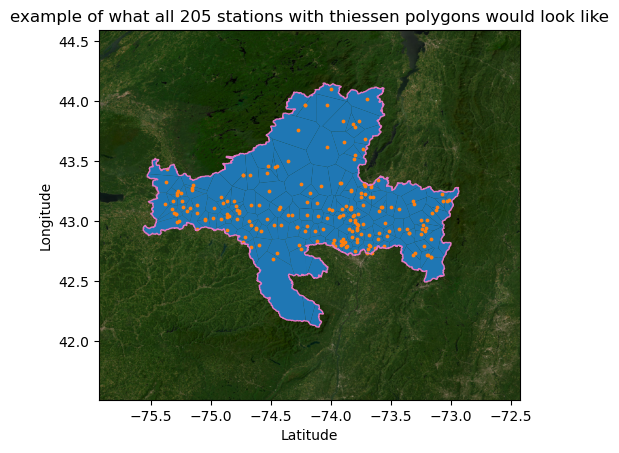

In [6]:
fig, ax = plt.subplots(1)
gdf_thiessen.plot(ax=ax)
gdf_stations_in_area.plot(ax=ax,color="C1",markersize=3) .plot()
outline.plot(ax=ax,edgecolor="C6",facecolor="None")
ax.set_title(f"example of what all {len(gdf_stations_in_area)} stations with thiessen polygons would look like")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

# add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
with rasterio.open(get_background_map("P_stations", bounds_stations)) as r:
    rioshow(r, ax=ax,zorder=-10)

in reality not all stations have data at once, only 4 stations stand between 1950 and 2020, to combat this, we create thiessen polygons for all combinations of stations

In [7]:
gdf_joined = gdf_stations_in_area.sjoin(gdf_thiessen)
lst_dfs_concat = []
for i in gdf_joined.index:
    station_name = gdf_joined.loc[i,"STATION"]
    station_area = gdf_joined.loc[i,"area"]
    df = df_lst_input[station_index_dict[station_name]][["PRCP"]].copy()
    df.rename(columns={'PRCP':f'{station_name}'},inplace=True)
    lst_dfs_concat.append(df)
df_combined = pd.concat(lst_dfs_concat, axis=1)

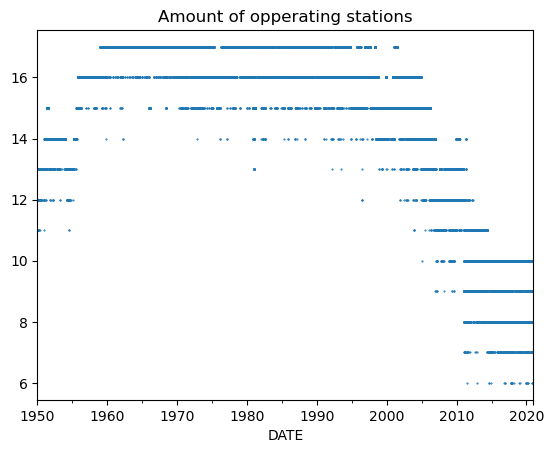

In [8]:
n_year = 50 # threshold for the number of years to be opperating
df_selected_combined = df_combined.loc["1950":"2020"].dropna(axis=1,thresh=365*n_year)
count_nans = df_selected_combined.apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)
(len(df_selected_combined.columns)- count_nans).plot(lw=0,marker=".",ms=1)
plt.title("Amount of opperating stations");

to speed thing up the threshold was lowered in this case, but a threshold of 20 continous years was used to generate the data set. An example is given below of how the polygon code looks 

In [9]:
# code to create thiessen polygons
from longsgis import voronoiDiagram4plg
def draw_thiessen_polygons(stations, boundary):
    """https://pypi.org/project/voronoi-diagram-for-polygons/"""
    warnings.filterwarnings("ignore", category=FutureWarning)
    vd = voronoiDiagram4plg(stations, boundary)
    return vd

In [10]:
columns = np.array(df_selected_combined.columns.to_list())
series_stations_not_na_txt = df_selected_combined.apply(lambda x: ','.join(columns[~np.isnan([x.loc[col] for col in x.index])]),axis=1)
df_stations_not_na_txt = pd.DataFrame(data=series_stations_not_na_txt,columns=["names_station"])
total_area = outline.to_crs("EPSG:26918").area.sum()
lst_df_joined = []
dict_df_joined = {}
for index, combination in enumerate(df_stations_not_na_txt['names_station'].unique()[:1]):
    ids_to_thiessen = combination.split(",")
    df_station_to_thiessen = gdf_stations_in_area.set_index("STATION").loc[ids_to_thiessen]
    thiessen_polygons = draw_thiessen_polygons(df_station_to_thiessen, outline)
    thiessen_polygons = thiessen_polygons.to_crs("epsg:26918")
    df_station_to_thiessen = df_station_to_thiessen.to_crs("epsg:26918")
    thiessen_polygons["Area_m2"] = thiessen_polygons.area
    df_joined = df_station_to_thiessen.sjoin(thiessen_polygons)
    
    # save the outputs to be used later, dict to get the index, list to store the data
    lst_df_joined.append(df_joined)
    dict_df_joined[combination] = index

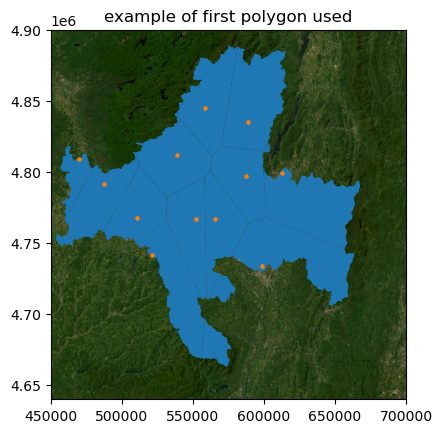

In [11]:
fig, ax = plt.subplots(1)
df_station_to_thiessen.plot(ax=ax, color="C1",zorder=10,markersize=5)
thiessen_polygons.plot(ax=ax)
ax.set_title("example of first polygon used")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

With the polygons generated the data can then be added by multiplyin P with the fraction & summing

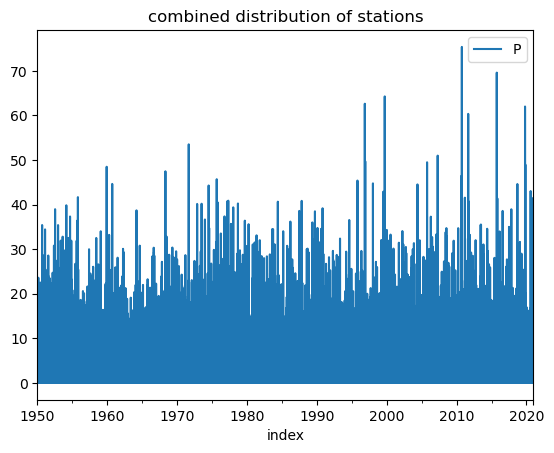

In [13]:
df_p = pd.read_parquet(f"{data_folder}\\P\\weighted_average_P.parquet")

fig, ax = plt.subplots(1)
df_p.plot(ax=ax)
ax.set_title("combined distribution of stations");

## 0.1.3 - T

Similar to P, T was loaded in from station data obtained from https://www.ncei.noaa.gov/cdo-web/. More info in notebook [0.1.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.3.T_combining_selected_data.ipynb)

In [18]:
gdf_stations = gpd.read_file(f'{gis_folder}\\location_temperature_stations_upperbains_26918.gpkg')

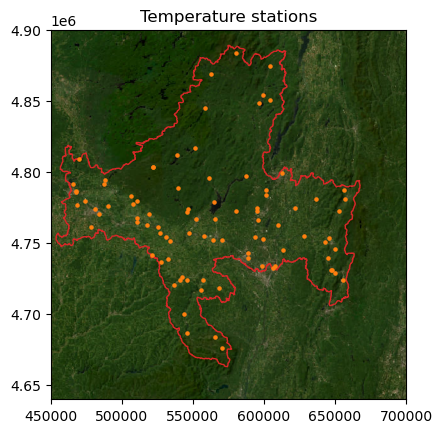

In [19]:
fig, ax = plt.subplots(1)
gdf_stations.plot(ax=ax, color="C1",zorder=10,markersize=5)
outline.to_crs("epsg:26918").plot(ax=ax,edgecolor='C3',facecolor="none")
ax.set_title("Temperature stations")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

In [20]:
df_station_ids = gdf_stations[["station ID"]].rename(columns={"station ID":"station_id"})
lst_t_dfs_max = []
lst_t_dfs_min = []
lst_elevation = []
for ids in df_station_ids.station_id.values:
    df_in = pd.read_parquet(f"{data_folder}\\T\\data parquet basin\\temp_{ids}.parquet")
    lst_elevation.append([ids,df_in["ELEVATION"].iloc[0]])
    df_in["DATE"] = pd.to_datetime( df_in["DATE"])
    df_in = df_in.set_index("DATE")
    df_in["TMAX"] = df_in["TMAX"].apply(lambda x: x if (x < 100) else np.nan)
    df_in["TMIN"] = df_in["TMIN"].apply(lambda x: x if (x < 100) else np.nan)
    df_in = df_in.rename(columns={"TMAX":f"TMAX_{ids}","TMIN":f"TMIN_{ids}"})
    df_in_max = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMIN_{ids}"])
    df_in_min = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMAX_{ids}"])
    lst_t_dfs_max.append(df_in_max)
    lst_t_dfs_min.append(df_in_min)

In [21]:
df_combined_max = pd.concat(lst_t_dfs_max,axis=1)
df_combined_mean_max = df_combined_max.mean(axis=1)

df_combined_min = pd.concat(lst_t_dfs_min,axis=1)
df_combined_mean_min = df_combined_min.mean(axis=1)

<AxesSubplot: xlabel='DATE'>

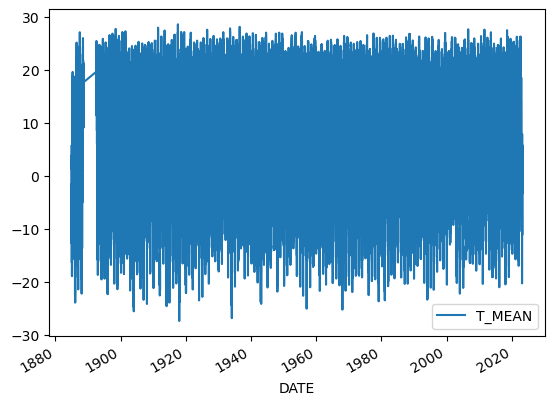

In [22]:
temp_mean_series = (df_combined_mean_max  +  df_combined_mean_min) /2
df_t = pd.DataFrame(data=temp_mean_series,columns=["T_MEAN"])
df_t.plot()

# 0.2 Q

**From the USGS website we can extract hydrological units for the basin**<br>
[USGS Watershed Boundary Dataset (WBD) for 2-digit Hydrologic Unit - 02 (published 20230306) GeoPackage](https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GPKG/WBD_02_HU2_GPKG.zip) using [USGS TNM Download (v2.0)](https://apps.nationalmap.gov/downloader/#/)
![map](Figures\wanted_hydrological_areas.png)

**The ids shown on the map can be loaded in**

In [23]:
gdf_wbdhu = gpd.read_file(f"{gis_folder}\\WBDHU8-hudson.gpkg",driver="GPKG",crs="EPSG:4326")  
huc8_ids = ",".join(gdf_wbdhu.huc8.values)
# However we only take the northern part
huc8_ids = ",".join(gdf_wbdhu.iloc[[0,2,3,4,8]].huc8.values)
huc8_ids

'02020002,02020003,02020004,02020001,02020005'

Which we can query

In [24]:
station_id_rest_query = f"https://waterservices.usgs.gov/nwis/dv/?format=rdb&huc={huc8_ids}&parameterCd=00060&siteType=ST&siteStatus=all"
page = urlopen(station_id_rest_query)
html_bytes = page.read()
html = html_bytes.decode("utf-8")

& process

In [25]:
# the 15th line contains the number of sites:
skip_rows = 15
line = html.split("\n")[skip_rows]
print(line)
n = int(line[line.find("following ")+len("following "):line.find(" site")].strip())

data = html.split("\n")[skip_rows+1:skip_rows+1+n]
data_ordered = []
for line in data:
    words = line[line.find("USGS"):].split(" ")
    type_id_name = words[:2] + [" ".join(words[2:])]
    data_ordered.append(type_id_name)
df_sites = pd.DataFrame(data=data_ordered,columns=["provider","site_no","name"])
df_sites.site_no = df_sites.site_no.astype(int)

df_sites.head(4)

# Data for the following 103 site(s) are contained in this file


,provider,site_no,name
0,USGS,131199050,FISHING BROOK (COUNTY LINE FLOW OUTLET) NR NEW...
1,USGS,1311992,ARBUTUS POND OUTLET NEAR NEWCOMB NY
2,USGS,1312000,HUDSON RIVER NEAR NEWCOMB NY
3,USGS,1313500,CEDAR R BELOW CHAIN LAKES NR INDIAN LAKE NY


for these site numbers we can get the location & plot them, see notebook [0.2.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.2.Q_webscrape%20locations%20.ipynb)

In [26]:
def plot_map(gdf_station, ax):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
        
    ax.set_xlim(-75.8,-72.8)
    ax.set_ylim(40.5, 44.5)
    # remove lat/lon markers
    # ax.set_xticks([])
    # ax.set_yticks([])

In [27]:
gdf_station = gpd.read_file(f"{gis_folder}\\discharge_stations.gpk", driver="GPKG")

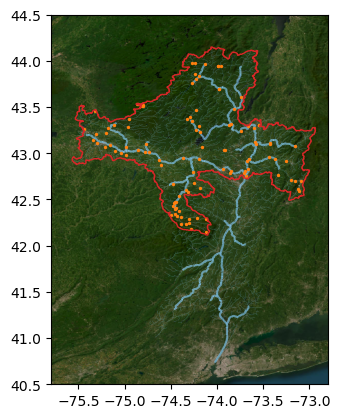

In [28]:
fig, ax = plt.subplots(1)
plot_map(gdf_station, ax)

These sites can then be loaded in, which can be found in notebook [0.2.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.3.Q_Loading%20discharge%20data.ipynb).<br>
We focussed on station 1358000 as this was at the bottom of the catchement closest to the outflow. 

In [ ]:
begin_end_date_csv = f"{data_folder}\\Q_ids_with_begin-end-date.csv"
df_id_dates = pd.read_csv(begin_end_date_csv,index_col=0)
df_id_dates.set_index("ID",inplace=True)

lst_data   = []
lst_errors = []
found_ids  = []

for path in glob.glob(f"{data_folder}\\Q\\*.parquet"):
    df = pd.read_parquet(path)
    # check columns integrity, else this will fail
    df = df[['agency_cd', 'site_no', 'Data codes', 'Q_m3_s_mean']]
    df = df[df["Q_m3_s_mean"]>-999]
    site_no = df['site_no'].iloc[0]
    found_ids.append(site_no)
    area = df_id_dates.loc[site_no,"Area_m2"]
    df["Area_USGS"] = area
    df["Q_mm_d"]  = df["Q_m3_s_mean"]  * 86400 / area * 1000  # s -> d, m3 -> mm
    lst_data.append(df)

In [ ]:
wanted_index = list(found_ids).index(1358000)

In [ ]:
def plot_map(ax, station_id):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # zoom on one station
    given_station = gdf_station.loc[[station_id]]
    given_station.plot(ax=ax, color="C0",markersize=20)
    x, y = given_station.geometry.x.iloc[0], given_station.geometry.y.iloc[0]
    n = 1
    ax.set_xlim(x- n,x + n)
    ax.set_ylim(y -(2*n/3),y + (2*n/3))


In [ ]:
df = lst_data[wanted_index]
fig, ax = plt.subplots(1,figsize=(15,3))
ax2 = ax.inset_axes([.79,.45, 0.55,0.55])
plot_map(ax2, int(df["site_no"].iloc[0]))
df[['Q_mm_d']].plot(ax=ax, alpha=0.5)#,lw=0, marker=".",markersize=0.5)
df[['Q_mm_d_hydro']].plot(ax=ax, alpha=0.3)#, lw=0, marker=".",markersize=0.5)
ax.set_title(f'Discharge for site: #{df["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_ylabel("Discharge in mm/d");